In [1]:
import numpy as np
import pandas as pd
import pydicom
from matplotlib import pyplot as plt
import os
from mask_functions import rle2mask, mask2rle
from google.cloud import storage

In [2]:
bucket = storage.Client().get_bucket("pneumothorax_chest_x-rays")

In [3]:
blobs = list(bucket.list_blobs(prefix='test/'))

In [4]:
df = pd.read_csv('./output/sample_submission.csv')
df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6067.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6214.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6177.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6655.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6359.151787519...,-1


In [5]:
import torch
import torch.utils.data
import collections
from tqdm import tqdm_notebook
from PIL import Image
import torchvision

class TorchDataset(torch.utils.data.Dataset):
    def __init__(self, blobs, df):
        self.blobs = blobs
        self.df = df
        
        self.image_info = collections.defaultdict(dict)
        
        i = 0
        for blob in tqdm_notebook(self.blobs):
            file_path = blob.name
            img_id = file_path.split('/')[-1][:-4]
            
            # skip the img_ids which are out of sample df
            df_temp = self.df.loc[self.df.ImageId == img_id]
            if not df_temp.iloc[0, 0]:
                continue
            
            dcm_path = './testset/{}.dcm'.format(img_id)
            png_path = './testset_png/{}.png'.format(img_id)
                
            # if the dcm is not downloaded, download it.
            if not os.path.exists(dcm_path):
                with open(dcm_path, 'wb') as file_obj:
                    blob.download_to_file(file_obj)  
            # if the png is not created, create it.
            if not os.path.exists(png_path):
                with open(png_path, 'wb') as file_obj:
                    dcm_data = pydicom.dcmread(dcm_path) #, force=True)  
                    img = dcm_data.pixel_array
                    img_mem = Image.fromarray(img)
                    img_mem.save(file_obj)
                
            self.image_info[i]["image_id"] = img_id
            self.image_info[i]["image_path"] = png_path
            i += 1
                
            
    def __getitem__(self, idx):
        # images
        img_path = self.image_info[idx]["image_path"]
        img = Image.open(img_path).convert("RGB")
        tsr = torchvision.transforms.ToTensor()(img)
        
#         # resize
#         tsr = img.resize((256, 256), resample=Image.BILINEAR)
#         tsr = torchvision.transforms.ToTensor()(tsr)

        return img, tsr, self.image_info[idx]["image_id"]
    

    def __len__(self):
        return len(self.image_info)

In [6]:
testset = TorchDataset(blobs, df)

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)

# load the trained parameter
model.load_state_dict(torch.load('./model/model_para_0816.pt'))
# model.load_state_dict(torch.load('./model/model.bin'))

# move model to the right device
model.to(device)

MaskRCNN(
  (transform): GeneralizedRCNNTransform()
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d()
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d()
          (relu): ReLU(inplace)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d()
          )
        )
    

In [9]:
# pick one image from the test set
img, tsr, img_id = testset[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([tsr.to(device)])

In [10]:
prediction

[{'boxes': tensor([[659.4875, 152.1092, 964.0744, 852.9567],
          [756.3307, 686.4139, 941.8176, 809.5459],
          [318.7099, 159.2009, 477.2341, 224.6483],
          [651.4066, 164.6527, 890.1573, 365.8221],
          [303.6555, 130.6330, 944.7989, 875.3848],
          [746.6462, 704.0377, 964.7936, 874.1215],
          [350.8357, 154.9444, 485.8178, 203.6176],
          [284.0023, 157.6667, 469.2262, 261.4271],
          [657.5235, 169.8183, 823.7830, 257.5643],
          [663.2596, 170.6248, 790.0642, 219.2803],
          [724.2609, 394.2619, 955.4370, 837.4153]], device='cuda:0'),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'),
  'scores': tensor([0.9301, 0.5256, 0.4983, 0.3943, 0.2923, 0.2172, 0.1551, 0.1278, 0.0994,
          0.0883, 0.0787], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0.

In [11]:
scores = prediction[0]['scores']
scores_binary = (scores >= 0.8) #threshold

# no score/mask or all the scores < threshold
if len(scores) ==0 or scores_binary.all == 0:
    rle = '-1'

else:
    masks = prediction[0]['masks'].mul(255).byte().cpu().numpy()
    mask_pred = np.zeros_like(masks[0, 0]).astype(np.uint64) #change type to prevent overflow
    for i, binary in enumerate(scores_binary):
        if binary ==1:
            mask_pred += masks[i, 0]
    mask_pred = (mask_pred > 127).astype(np.uint8)
    mask_pred = np.where(mask_pred ==0, 0, 255)
    rle = mask2rle(mask_pred.T, 1024, 1024)
    
#     # resize
#     mask_temp = Image.fromarray(mask_pred).resize((1024, 1024), resample=Image.BILINEAR)
#     mask_temp = np.array(mask_temp)
#     rle = mask2rle(mask_temp.T, 1024, 1024)
    
    if rle == '':
        rle = '-1'

In [12]:
rle

'679125 29 988 43 979 47 975 51 970 56 966 60 961 65 957 68 953 73 950 76 947 79 944 83 940 86 937 87 937 88 935 89 934 90 934 91 933 91 932 92 932 93 930 94 930 94 930 95 928 96 928 97 927 98 926 98 925 100 924 100 924 101 923 101 922 103 921 103 921 103 921 103 921 103 921 103 921 102 922 102 922 102 922 102 922 101 923 101 923 101 923 101 923 101 923 101 924 100 924 100 924 100 924 100 924 100 924 100 924 100 924 100 924 100 924 100 925 99 925 100 924 100 924 100 924 100 925 100 924 100 924 100 924 100 924 101 924 100 924 100 924 101 923 101 923 101 924 101 923 101 923 101 923 101 923 102 923 101 923 100 925 99 925 99 926 98 926 98 927 97 927 97 928 96 928 95 930 94 930 95 930 94 930 94 930 94 930 95 930 94 931 93 931 93 932 93 931 93 932 92 933 91 934 89 936 88 937 86 939 85 939 84 941 83 942 81 943 81 944 80 944 79 945 80 945 79 945 80 944 81 944 80 944 81 943 81 944 81 943 81 943 82 943 81 943 80 944 79 946 77 947 76 948 75 949 74 951 72 952 72 952 71 953 70 487 2 466 69 485 4 46

In [13]:
mask_0 = np.zeros((1024, 1024))
mask_0 = np.uint8(mask_0)

In [14]:
rle_0 = mask2rle(mask_0.T, 1024, 1024)
rle_0

''

In [15]:
np.unique(rle2mask(rle_0, 1024, 1024).T)

array([0.])

In [16]:
mask_rle = rle2mask(rle, 1024, 1024).T
mask_rle = np.uint8(mask_rle)

In [17]:
np.unique(mask_rle)

array([  0, 255], dtype=uint8)

In [18]:
np.unique(mask_pred)

array([  0, 255])

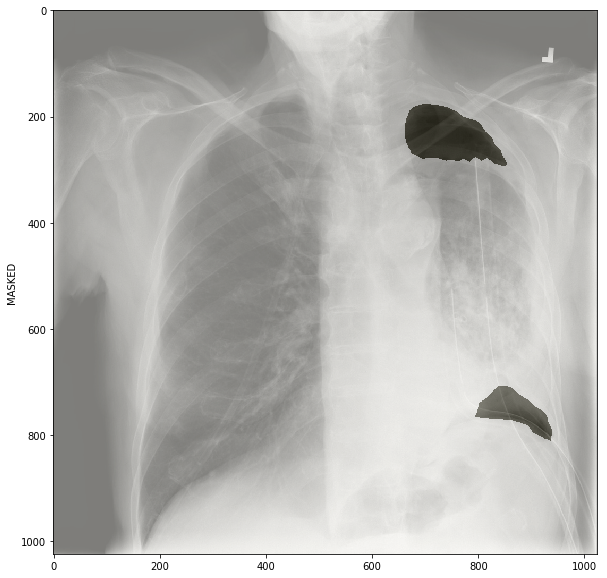

In [22]:
plt.figure(figsize=(10,10))
plt.ylabel('MASKED')

plt.imshow(img, cmap=plt.cm.bone)
plt.imshow(mask_pred, alpha=0.3, cmap="Reds")
# plt.imshow(mask_temp, alpha=0.3, cmap="Greens")
plt.imshow(mask_rle, alpha=0.3, cmap="Greens")

In [23]:
# predict on the entire test set
# put the model in evaluation mode
model.eval()

with torch.no_grad():
    test_list = list()
    
    for i in tqdm_notebook(range(len(testset))):
        img, tsr, img_id = testset[i]
        prediction = model([tsr.to(device)])
###
        scores = prediction[0]['scores']
        scores_binary = (scores >= 0.8) #threshold

        # no score/mask or all the scores < threshold
        if len(scores) ==0 or scores_binary.all == 0:
            rle = '-1'

        else:
            masks = prediction[0]['masks'].mul(255).byte().cpu().numpy()
            mask_pred = np.zeros_like(masks[0, 0]).astype(np.uint64) #change type to prevent overflow
            for i, binary in enumerate(scores_binary):
                if binary ==1:
                    mask_pred += masks[i, 0]
            mask_pred = (mask_pred > 127).astype(np.uint8)
            mask_pred = np.where(mask_pred ==0, 0, 255)
            rle = mask2rle(mask_pred.T, 1024, 1024)

        #     # resize
        #     mask_temp = Image.fromarray(mask_pred).resize((1024, 1024), resample=Image.BILINEAR)
        #     mask_temp = np.array(mask_temp)
        #     rle = mask2rle(mask_temp.T, 1024, 1024)

            if rle == '':
                rle = '-1'
###
    
        test_list.append([img_id, rle])

In [24]:
sample_order = list(df['ImageId'])

In [25]:
pred_list = [tuple for x in sample_order for tuple in test_list if tuple[0] == x]

In [26]:
df_pred = pd.DataFrame(pred_list, columns = df.columns.values) 

In [27]:
df_pred.to_csv('./output/submission_0816.csv', index=False)